In [1]:
# -*- coding: utf-8 -*-
"""
"""
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like #datareader problem probably fixed in next version of datareader
from pandas_datareader import data as pdr
import datetime
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as sf
from pyspark.sql.window import Window
import numpy as np
import fix_yahoo_finance as yf
from math import log
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
import matplotlib.pyplot as plt
from pyspark.ml.regression import DecisionTreeRegressor


In [2]:
yf.pdr_override() # <== that's all it takes :-)


start_date=datetime.date(1980, 12, 12)
end_date= datetime.date(2018, 1, 1)

stock_list = ["AAPL"]

stock_str = ""
for i in range(len(stock_list)):
    stock_str  = stock_str + stock_list[i] + "."

main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date, end=end_date)
     #df.drop(['Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Adj Close': 'Adj_close'}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 
           
#main_df["Date"]=main_df.index
main_df.reset_index(level=0, inplace=True)

[ 0% ][*********************100%***********************] 1 of 1 downloaded

In [3]:
df = spark.createDataFrame(df)
df = df.withColumn("ticker", sf.lit("AAPL"))
df.show(10)

+-------------------+--------+--------+-------------------+-------------------+--------------------+---------+------+
 Date| Open| High| Low| Close| Adj_close| Volume|ticker|
+-------------------+--------+--------+-------------------+-------------------+--------------------+---------+------+
1980-12-12 00:00:00|0.513393|0.515625| 0.513393| 0.513393| 0.023007|117258400| AAPL|
1980-12-15 00:00:00|0.488839|0.488839|0.48660699999999996|0.48660699999999996| 0.021807| 43971200| AAPL|
1980-12-16 00:00:00|0.453125|0.453125|0.45089300000000004|0.45089300000000004|0.020206000000000002| 26432000| AAPL|
1980-12-17 00:00:00|0.462054|0.464286| 0.462054| 0.462054| 0.020706| 21610400| AAPL|
1980-12-18 00:00:00|0.475446|0.477679| 0.475446| 0.475446| 0.021307| 18362400| AAPL|
1980-12-19 00:00:00|0.504464|0.506696| 0.504464| 0.504464| 0.022607| 12157600| AAPL|
1980-12-22 00:00:00|0.529018| 0.53125| 0.529018| 0.529018| 0.023707| 9340800| AAPL|
1980-12-23 00:00:00|0.551339|0.553571| 0.551339| 0.551339| 0.024708| 11737600| AAPL|
1980-12-24 00:00:00|0.580357|0.582589| 0.580357| 0.580357| 0.026008| 12000800| AAPL|
1980-12-26 00:00:00|0.633929|0.636161| 0.633929| 0.633929|0.028408999999999997| 13893600| AAPL|
+-------------------+--------+--------+-------------------+-------------------+--------------------+---------+------+
only showing top 10 rows

In [4]:
w = Window().partitionBy("ticker").orderBy("date")
df = df.withColumn("Log_Adj_Close", sf.log("Adj_close"))

#Predictions
df = df.withColumn("pred_daily", sf.lag("Log_Adj_Close", -1).over(w))
df = df.withColumn("pred_weekly", sf.lag("Log_Adj_Close", -5).over(w))
df = df.withColumn("pred_biweekly", sf.lag("Log_Adj_Close", -10).over(w))
df = df.withColumn("pred_monthly", sf.lag("Log_Adj_Close", -21).over(w))
df = df.withColumn("pred_quarterly", sf.lag("Log_Adj_Close", -84).over(w))
df = df.withColumn("pred_annually", sf.lag("Log_Adj_Close", -252).over(w))

#Normalize data
df = df.withColumn("log_open", sf.log("Open"))
df = df.withColumn("log_high", sf.log("High"))
df = df.withColumn("log_low", sf.log("Low"))
df = df.withColumn("Volume", sf.log("Volume"))

#Returns
df = df.withColumn("log_return", -1* (sf.col("Log_Adj_Close") - sf.lag("Log_Adj_Close", 1).over(w)) / sf.lag("Log_Adj_Close", 5).over(w))
df = df.withColumn("weekly_log_return", -1* (sf.col("Log_Adj_Close") - sf.lag("Log_Adj_Close", 5).over(w)) / sf.lag("Log_Adj_Close", 10).over(w))
df = df.withColumn("biweekly_log_return", -1* (sf.col("Log_Adj_Close") - sf.lag("Log_Adj_Close", 10).over(w)) / sf.lag("Log_Adj_Close", 21).over(w))
df = df.withColumn("monthly_log_return", -1* (sf.col("Log_Adj_Close") - sf.lag("Log_Adj_Close", 21).over(w)) / sf.lag("Log_Adj_Close", 42).over(w))
df = df.withColumn("quarterly_log_return", -1* (sf.col("Log_Adj_Close") - sf.lag("Log_Adj_Close", 84).over(w)) / sf.lag("Log_Adj_Close", 84).over(w))
df = df.withColumn("annual_log_return", -1* (sf.col("Log_Adj_Close") - sf.lag("Log_Adj_Close", 252).over(w)) / sf.lag("Log_Adj_Close", 252).over(w))

#Volume
df = df.withColumn("daily_volume_diff", (sf.col("Volume") - sf.lag("Volume", 1).over(w))) 
df = df.withColumn("weekly_volume_diff", (sf.col("Volume") - sf.lag("Volume", 5).over(w))) 
df = df.withColumn("biweekly_volume_diff", (sf.col("Volume") - sf.lag("Volume", 10).over(w))) 
df = df.withColumn("monthly_volume_diff", (sf.col("Volume") - sf.lag("Volume", 21).over(w))) 
df = df.withColumn("quarterly_volume_diff", (sf.col("Volume") - sf.lag("Volume", 84).over(w))) 
df = df.withColumn("annual_volume_diff", (sf.col("Volume") - sf.lag("Volume", 252).over(w))) 

#Everything else
w = Window.orderBy('Date').rowsBetween(-5, 0)
df = df.withColumn("weekly_mean", sf.avg('log_return').over(w))
df = df.withColumn("weekly_std", sf.stddev('log_return').over(w))
df = df.withColumn("weekly_volume_mean", sf.avg('Volume').over(w))
df = df.withColumn("weekly_volume_std", sf.stddev('Volume').over(w))

w = Window.orderBy('Date').rowsBetween(-10, 0)
df = df.withColumn("biweekly_mean", sf.avg('log_return').over(w))
df = df.withColumn("biweekly_std", sf.stddev('log_return').over(w))
df = df.withColumn("biweekly_volume_mean", sf.avg('Volume').over(w))
df = df.withColumn("biweekly_volume_std", sf.stddev('Volume').over(w))

w = Window.orderBy('Date').rowsBetween(-21, 0)
df = df.withColumn("monthly_mean", sf.avg('log_return').over(w))
df = df.withColumn("monthly_std", sf.stddev('log_return').over(w))
df = df.withColumn("monthly_volume_mean", sf.avg('Volume').over(w))
df = df.withColumn("monthly_volume_std", sf.stddev('Volume').over(w))

w = Window.orderBy('Date').rowsBetween(-84, 0)
df = df.withColumn("quarterly_mean", sf.avg('log_return').over(w))
df = df.withColumn("quarterly_std", sf.stddev('log_return').over(w))
df = df.withColumn("quarterly_volume_mean", sf.avg('Volume').over(w))
df = df.withColumn("quarterly_volume_std", sf.stddev('Volume').over(w))

w = Window.orderBy('Date').rowsBetween(-126, 0)
df = df.withColumn("semiannual_mean", sf.avg('log_return').over(w))
df = df.withColumn("semiannual_std", sf.stddev('log_return').over(w))
df = df.withColumn("semiannual_volume_mean", sf.avg('Volume').over(w))
df = df.withColumn("semiannual_volume_std", sf.stddev('Volume').over(w))

w = Window.orderBy('Date').rowsBetween(-252, 0)
df = df.withColumn("annual_mean", sf.avg('log_return').over(w))
df = df.withColumn("annual_std", sf.stddev('log_return').over(w))
df = df.withColumn("annual_volume_mean", sf.avg('Volume').over(w))
df = df.withColumn("annual_volume_std", sf.stddev('Volume').over(w))

#Custom
w = Window.orderBy('Date').rowsBetween(-1, 0)
df = df.withColumn("daily_mean", sf.avg('log_return').over(w))

w = Window.orderBy('Date').rowsBetween(-84, 0)
df = df.withColumn("quarterly_mean", sf.avg('log_return').over(w))

df=df.drop("ticker", "Close", "Adj_close", "Open", "High", "Low", "Volume")

In [5]:
# df2 = df.select('Date', sf.date_format('Date', 'u').alias('dow'), sf.date_format('Date', 'd').alias('day'), sf.date_format('Date', 'D').alias('doy'), sf.date_format('Date', 'W').alias('wom'), sf.date_format('Date', 'L').alias('moy'), sf.date_format('Date', 'w').alias('woy')) #, date_format('Date', 'E').alias('day'))
# df3=df2.orderBy("Date")


# indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in list(set(df3.columns)-set(["Date"]))]
# one_hot = [OneHotEncoder(inputCol= column +"_index", outputCol= column + "_one_hot") for column in list(set(df3.columns)-set(["Date"]))]

# pipeline = Pipeline(stages=indexers +one_hot )
# df_r = pipeline.fit(df3).transform(df3)

# df_hot = df_r.select('Date','moy_one_hot', 'wom_one_hot', 'doy_one_hot', 'woy_one_hot', 'day_one_hot', 'dow_one_hot')

# df = df.join(df_hot, "Date")



In [6]:
df = df.na.drop()

In [7]:
assembler = VectorAssembler(inputCols=['Log_Adj_Close',
                                           'log_open',
                                           'log_high',
                                           'log_low',
                                           'log_return',
                                           'weekly_log_return',
                                           'biweekly_log_return',
                                           'monthly_log_return',
                                           'quarterly_log_return',
                                           'annual_log_return',
                                           'daily_volume_diff',
                                           'weekly_volume_diff',
                                           'biweekly_volume_diff',
                                           'monthly_volume_diff',
                                           'quarterly_volume_diff',
                                           'annual_volume_diff',
                                           'weekly_mean',
                                           'weekly_std',
                                           'weekly_volume_mean',
                                           'weekly_volume_std',
                                           'biweekly_mean',
                                           'biweekly_std',
                                           'biweekly_volume_mean',
                                           'biweekly_volume_std',
                                           'monthly_mean',
                                           'monthly_std',
                                           'monthly_volume_mean',
                                           'monthly_volume_std',
                                           'quarterly_mean',
                                           'quarterly_std',
                                           'quarterly_volume_mean',
                                           'quarterly_volume_std',
                                           'semiannual_mean',
                                           'semiannual_std',
                                           'semiannual_volume_mean',
                                           'semiannual_volume_std',
                                           'annual_mean',
                                           'annual_std',
                                           'annual_volume_mean',
                                           'annual_volume_std',
                                           'daily_mean'
                                            ], outputCol="features")
output = assembler.transform(df)
df = output.select('Date',
                   'features',
                   'pred_daily',
                   'pred_weekly',
                   'pred_biweekly',
                   'pred_monthly',
                   'pred_quarterly',
                   'pred_annually')

In [8]:
w = Window.partitionBy().orderBy("Date")

df_final = df.withColumn("rank", sf.percent_rank().over(w))

df_final=df_final.where('rank > 0.027' )

test_df = df_final.where("rank >= .7").drop("rank")
#test_df.show()

train_df = df_final.where("rank < .7").drop("rank")

In [9]:
train_df = train_df.drop('Date')
test_df = test_df.drop('Date')

In [10]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [11]:
lr = LinearRegression(maxIter=10)

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)



In [12]:
train_df_daily = train_df.withColumnRenamed("pred_daily", "label").select("features", "label")
test_df_daily = test_df.withColumnRenamed("pred_daily", "label").select("features", "label")
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_df_daily)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
lr_predictions = model.transform(test_df_daily)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % lr_evaluator.evaluate(lr_predictions))

RMSE on test data = 0.037451

In [13]:
print(smape(np.array(lr_predictions.select('label').rdd.map(lambda row : row[0]).collect()), np.array(lr_predictions.select('prediction').rdd.map(lambda row : row[0]).collect())))

0.920450162717

In [14]:
model.bestModel.coefficients

Out[ 14 ]: DenseVector([0.9823, 0.0113, 0.0158, 0.0062, -0.0002, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0004, 0.0002, -0.0004, -0.0, 0.0011, 0.0003, -0.0, -0.0016, 0.0001, -0.0002, -0.0001, -0.0003, -0.0011, 0.0004, 0.0001, -0.0019, 0.0002, 0.0001, 0.0001, -0.0003, 0.0407, -0.0046, -0.0002, 0.0009, 0.0215, -0.0047, 0.0012, 0.001, -0.0408, 0.0001])

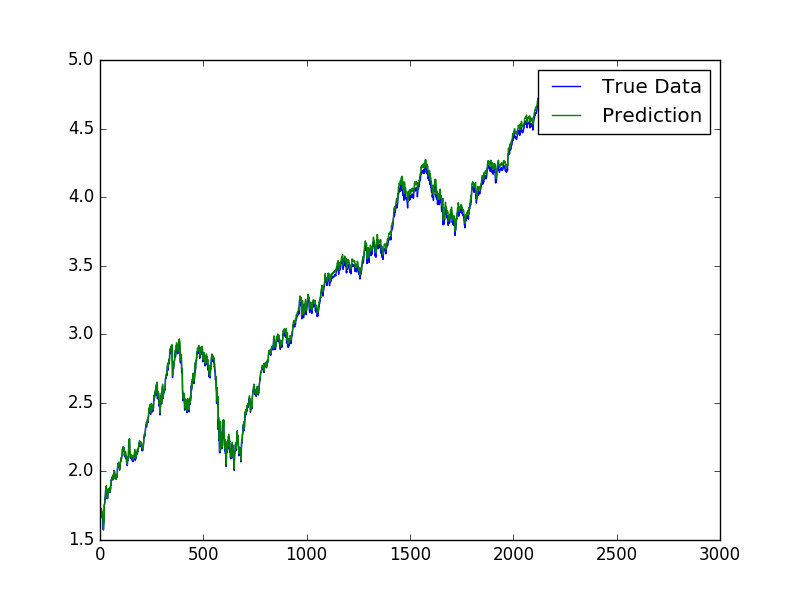

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lr_predictions.select('label').rdd.map(lambda row : row[0]).collect(), label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(lr_predictions.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
plt.legend()
display(fig)

In [16]:
train_df_weekly = train_df.withColumnRenamed("pred_weekly", "label").select("features", "label")
test_df_weekly = test_df.withColumnRenamed("pred_weekly", "label").select("features", "label")
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_df_weekly)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
lr_predictions = model.transform(test_df_weekly)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % lr_evaluator.evaluate(lr_predictions))

RMSE on test data = 0.0520765

In [17]:
print(smape(np.array(lr_predictions.select('label').rdd.map(lambda row : row[0]).collect()), np.array(lr_predictions.select('prediction').rdd.map(lambda row : row[0]).collect())))

1.25692919107

In [18]:
model.bestModel.coefficients

Out[ 18 ]: DenseVector([0.9832, 0.0133, 0.0112, 0.0041, -0.0, -0.0001, -0.0, 0.0001, -0.0, -0.0, 0.0001, -0.0015, -0.0023, -0.0028, 0.0025, 0.0034, 0.0018, -0.0001, -0.0049, 0.0067, -0.0025, -0.0007, -0.0012, -0.0026, 0.0024, 0.0007, -0.0041, 0.0023, -0.0013, 0.0008, 0.0198, 0.0497, -0.0078, -0.0008, -0.0084, 0.0189, 0.0002, 0.0007, -0.0022, -0.0777, 0.0002])

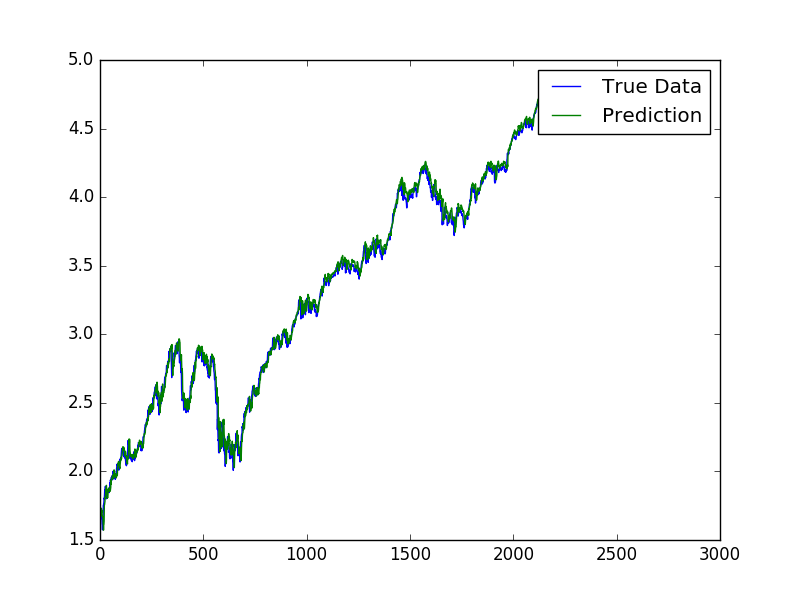

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lr_predictions.select('label').rdd.map(lambda row : row[0]).collect(), label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(lr_predictions.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
plt.legend()
display(fig)

In [20]:
train_df_biweekly = train_df.withColumnRenamed("pred_biweekly", "label").select("features", "label")
test_df_biweekly = test_df.withColumnRenamed("pred_biweekly", "label").select("features", "label")
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_df_biweekly)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
lr_predictions = model.transform(test_df_biweekly)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % lr_evaluator.evaluate(lr_predictions))

RMSE on test data = 0.0688204

In [21]:
print(smape(np.array(lr_predictions.select('label').rdd.map(lambda row : row[0]).collect()), np.array(lr_predictions.select('prediction').rdd.map(lambda row : row[0]).collect())))

1.67195174478

In [22]:
model.bestModel.coefficients

Out[ 22 ]: DenseVector([0.984, 0.0117, 0.0085, 0.0031, 0.0, -0.0001, 0.0, -0.0, -0.0001, -0.0, -0.0021, -0.0064, -0.0012, 0.0002, 0.0042, 0.0063, 0.0011, -0.0005, -0.0123, 0.0035, -0.0034, -0.0, -0.0059, 0.0023, 0.0057, 0.0007, -0.0007, 0.0093, -0.0081, 0.0019, 0.0396, 0.0894, 0.0001, -0.0018, -0.0088, 0.0117, 0.0009, 0.0, -0.0114, -0.1504, 0.0003])

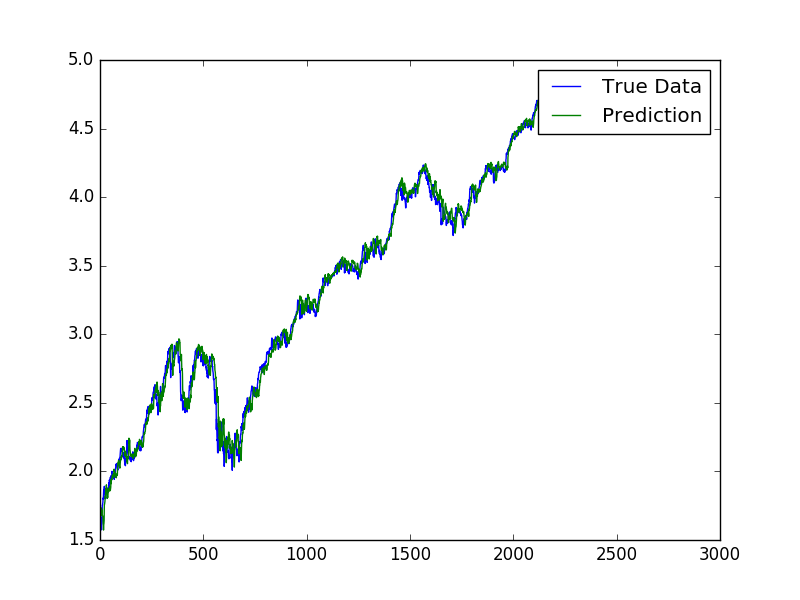

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lr_predictions.select('label').rdd.map(lambda row : row[0]).collect(), label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(lr_predictions.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
plt.legend()
display(fig)

In [24]:
train_df_monthly = train_df.withColumnRenamed("pred_monthly", "label").select("features", "label")
test_df_monthly = test_df.withColumnRenamed("pred_monthly", "label").select("features", "label")
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_df_monthly)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
lr_predictions = model.transform(test_df_monthly)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % lr_evaluator.evaluate(lr_predictions))

RMSE on test data = 0.147883

In [25]:
print(smape(np.array(lr_predictions.select('label').rdd.map(lambda row : row[0]).collect()), np.array(lr_predictions.select('prediction').rdd.map(lambda row : row[0]).collect())))

3.45382257459

In [26]:
model.bestModel.coefficients

Out[ 26 ]: DenseVector([0.9653, 0.0008, -0.0132, 0.0147, -0.0001, -0.0001, -0.0001, 0.0, -0.0001, -0.0, -0.0023, -0.008, -0.0035, -0.0014, 0.0129, 0.0036, 0.0001, -0.0004, -0.0124, 0.0188, 0.0002, 0.0018, 0.0096, 0.0197, 0.0011, -0.0002, -0.0283, 0.0119, 0.0037, 0.0051, 0.0494, 0.1818, 0.0142, -0.0053, 0.0559, 0.0852, 0.0557, -0.0016, 0.0348, -0.3678, 0.0001])

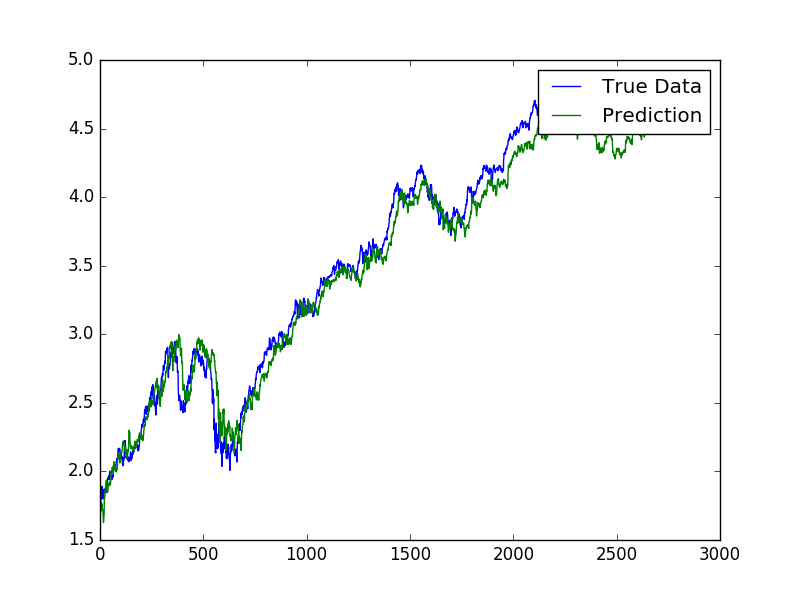

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lr_predictions.select('label').rdd.map(lambda row : row[0]).collect(), label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(lr_predictions.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
plt.legend()
display(fig)

In [28]:
train_df_quarterly = train_df.withColumnRenamed("pred_quarterly", "label").select("features", "label")
test_df_quarterly = test_df.withColumnRenamed("pred_quarterly", "label").select("features", "label")
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_df_quarterly)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
lr_predictions = model.transform(test_df_monthly)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % lr_evaluator.evaluate(lr_predictions))

RMSE on test data = 0.369251

In [29]:
print(smape(np.array(lr_predictions.select('label').rdd.map(lambda row : row[0]).collect()), np.array(lr_predictions.select('prediction').rdd.map(lambda row : row[0]).collect())))

8.47258016375

In [30]:
model.bestModel.coefficients

Out[ 30 ]: DenseVector([0.9471, -0.0323, -0.0721, 0.0157, -0.0001, 0.0, -0.0009, -0.0004, 0.0001, -0.0, -0.0055, -0.0026, -0.005, -0.0005, -0.0002, 0.0254, 0.0009, -0.0007, 0.0041, -0.0249, -0.0098, 0.0004, 0.0052, 0.0496, -0.002, 0.0081, -0.0065, 0.0902, -0.0081, 0.0048, 0.0154, 0.2742, 0.0991, -0.0136, 0.259, 0.6376, 0.1841, -0.0075, 0.0263, -1.4562, 0.0005])

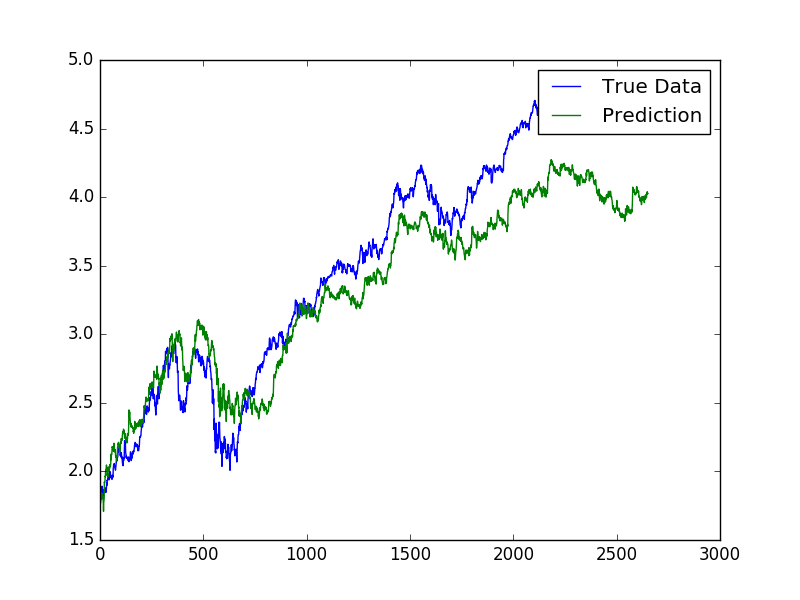

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lr_predictions.select('label').rdd.map(lambda row : row[0]).collect(), label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(lr_predictions.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
plt.legend()
display(fig)

In [32]:
gbt = GBTRegressor(maxIter=10)

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(gbt.featureSubsetStrategy, ['log2', 'all', 'onethird']) \
    .addGrid(gbt.lossType, ['squared', 'absolute'])\
    .build()

tvs = TrainValidationSplit(estimator=gbt,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)


In [33]:
train_df_daily = train_df.withColumnRenamed("pred_daily", "label").select("features", "label")
test_df_daily = test_df.withColumnRenamed("pred_daily", "label").select("features", "label")
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_df_daily)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
gbt_predictions = model.transform(test_df_daily)

gbt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))

RMSE on test data = 1.97131

In [34]:
print(smape(np.array(gbt_predictions.select('label').rdd.map(lambda row : row[0]).collect()), np.array(gbt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect())))

61.3866209888

In [35]:
model.bestModel.featureImportances

Out[ 14 ]: SparseVector(41, {0: 0.4186, 1: 0.0164, 2: 0.0611, 3: 0.064, 4: 0.0005, 5: 0.0016, 6: 0.0051, 7: 0.0056, 8: 0.0508, 9: 0.0692, 10: 0.0024, 11: 0.0039, 12: 0.0032, 13: 0.0, 14: 0.0008, 15: 0.0018, 16: 0.0034, 17: 0.005, 18: 0.0096, 19: 0.0032, 20: 0.0108, 21: 0.0168, 22: 0.012, 23: 0.0106, 24: 0.0076, 25: 0.0105, 26: 0.0235, 27: 0.0043, 28: 0.0207, 29: 0.0045, 30: 0.0108, 31: 0.0151, 32: 0.0382, 33: 0.0203, 34: 0.0165, 35: 0.024, 36: 0.0097, 37: 0.0003, 38: 0.0075, 39: 0.01, 40: 0.0001})

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(gbt_predictions.select('label').rdd.map(lambda row : row[0]).collect(), label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(gbt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
plt.legend()
display(fig)

In [37]:
train_df_weekly = train_df.withColumnRenamed("pred_weekly", "label").select("features", "label")
test_df_weekly = test_df.withColumnRenamed("pred_weekly", "label").select("features", "label")
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_df_weekly)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
gbt_predictions = model.transform(test_df_weekly)

gbt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))

In [38]:
print(smape(np.array(gbt_predictions.select('label').rdd.map(lambda row : row[0]).collect()), np.array(gbt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect())))

87.8578836854

In [39]:
model.bestModel.featureImportances

Out[ 39 ]: SparseVector(41, {0: 0.3322, 1: 0.0134, 2: 0.0162, 3: 0.0556, 4: 0.0004, 5: 0.006, 6: 0.0025, 7: 0.0083, 8: 0.0187, 9: 0.0317, 10: 0.0029, 11: 0.0001, 12: 0.0013, 14: 0.004, 15: 0.001, 16: 0.0049, 17: 0.0111, 18: 0.0016, 19: 0.0092, 20: 0.0201, 21: 0.0021, 22: 0.0168, 23: 0.0243, 24: 0.0146, 25: 0.0141, 26: 0.0309, 27: 0.0197, 28: 0.0484, 29: 0.02, 30: 0.0419, 31: 0.0131, 32: 0.0376, 33: 0.011, 34: 0.0333, 35: 0.0387, 36: 0.0169, 37: 0.0212, 38: 0.0116, 39: 0.0403, 40: 0.0023})

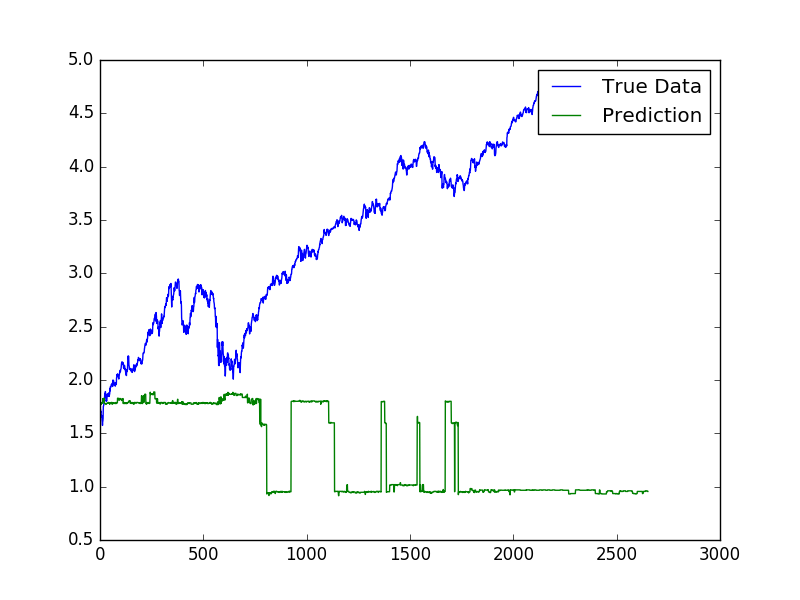

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(gbt_predictions.select('label').rdd.map(lambda row : row[0]).collect(), label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(gbt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
plt.legend()
display(fig)

In [41]:
train_df_biweekly = train_df.withColumnRenamed("pred_biweekly", "label").select("features", "label")
test_df_biweekly = test_df.withColumnRenamed("pred_biweekly", "label").select("features", "label")
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_df_biweekly)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
gbt_predictions = model.transform(test_df_biweekly)

gbt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))

RMSE on test data = 1.97092

In [42]:
print(smape(np.array(gbt_predictions.select('label').rdd.map(lambda row : row[0]).collect()), np.array(gbt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect())))

61.5387665433

In [43]:
model.bestModel.featureImportances

Out[ 43 ]: SparseVector(41, {0: 0.1947, 1: 0.0197, 2: 0.0183, 3: 0.0263, 4: 0.001, 5: 0.0081, 6: 0.0021, 7: 0.0169, 8: 0.0277, 9: 0.049, 11: 0.0008, 13: 0.0011, 14: 0.0041, 15: 0.0, 17: 0.0093, 18: 0.0234, 19: 0.0022, 20: 0.0066, 21: 0.0197, 22: 0.0063, 23: 0.0254, 24: 0.0061, 25: 0.0201, 26: 0.0338, 27: 0.0318, 28: 0.0222, 29: 0.0522, 30: 0.0315, 31: 0.0545, 32: 0.0231, 33: 0.0377, 34: 0.0208, 35: 0.0718, 36: 0.0375, 37: 0.0162, 38: 0.0364, 39: 0.0416})

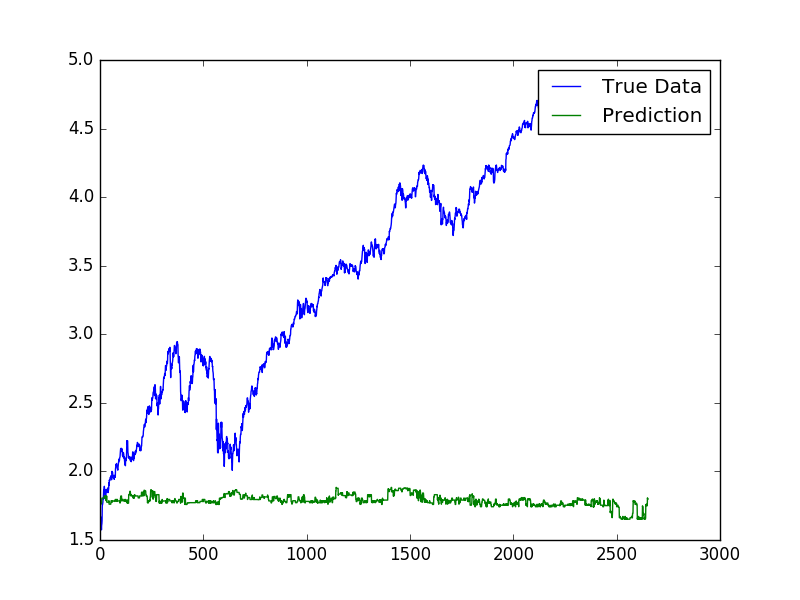

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(gbt_predictions.select('label').rdd.map(lambda row : row[0]).collect(), label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(gbt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
plt.legend()
display(fig)

In [45]:
train_df_monthly = train_df.withColumnRenamed("pred_monthly", "label").select("features", "label")
test_df_monthly = test_df.withColumnRenamed("pred_monthly", "label").select("features", "label")
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_df_monthly)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
gbt_predictions = model.transform(test_df_monthly)

gbt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))

RMSE on test data = 2.06815

In [46]:
print(smape(np.array(gbt_predictions.select('label').rdd.map(lambda row : row[0]).collect()), np.array(gbt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect())))

69.5239401507

In [47]:
model.bestModel.featureImportances

Out[ 47 ]: SparseVector(41, {0: 0.1237, 1: 0.0108, 2: 0.0161, 3: 0.0042, 4: 0.0011, 5: 0.0067, 6: 0.0175, 7: 0.0313, 8: 0.0319, 9: 0.0389, 10: 0.0023, 12: 0.0028, 13: 0.0019, 14: 0.0021, 15: 0.0104, 16: 0.0019, 17: 0.0091, 18: 0.0094, 19: 0.0064, 20: 0.0109, 21: 0.0279, 22: 0.0243, 23: 0.0069, 24: 0.0208, 25: 0.0165, 26: 0.0507, 27: 0.0171, 28: 0.0314, 29: 0.0535, 30: 0.0214, 31: 0.0867, 32: 0.0434, 33: 0.0306, 34: 0.0441, 35: 0.0321, 36: 0.0379, 37: 0.0301, 38: 0.0354, 39: 0.0476, 40: 0.0022})

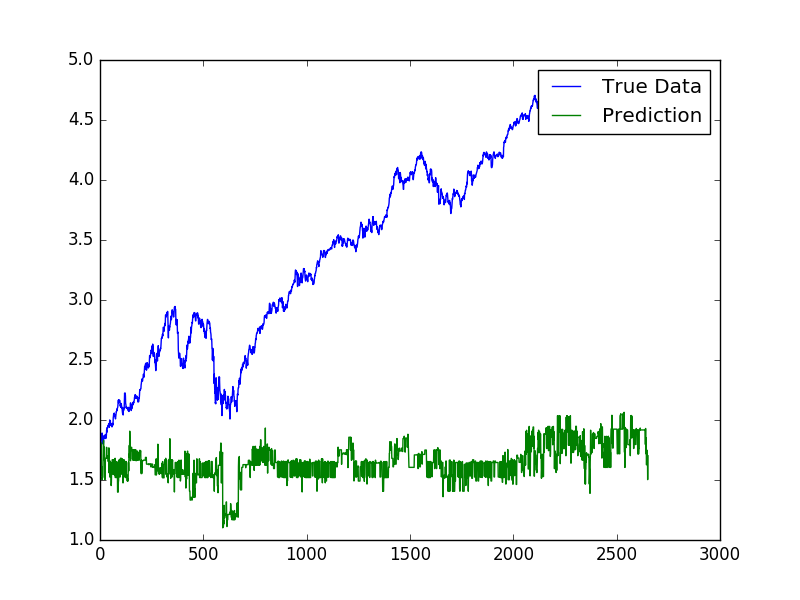

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(gbt_predictions.select('label').rdd.map(lambda row : row[0]).collect(), label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(gbt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
plt.legend()
display(fig)

In [49]:
train_df_quarterly = train_df.withColumnRenamed("pred_quarterly", "label").select("features", "label")
test_df_quarterly = test_df.withColumnRenamed("pred_quarterly", "label").select("features", "label")
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_df_quarterly)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
gbt_predictions = model.transform(test_df_quarterly)

gbt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))

RMSE on test data = 1.88059

In [50]:
print(smape(np.array(gbt_predictions.select('label').rdd.map(lambda row : row[0]).collect()), np.array(gbt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect())))

54.9740195378

In [51]:
model.bestModel.featureImportances

Out[ 51 ]: SparseVector(41, {0: 0.1235, 1: 0.0051, 2: 0.0037, 3: 0.0151, 4: 0.003, 5: 0.0021, 6: 0.0015, 7: 0.0202, 8: 0.0325, 9: 0.026, 10: 0.0037, 14: 0.0022, 15: 0.012, 16: 0.0041, 17: 0.0058, 18: 0.0014, 19: 0.0059, 20: 0.0009, 21: 0.0316, 22: 0.0192, 23: 0.0073, 24: 0.0336, 25: 0.031, 26: 0.0272, 27: 0.0254, 28: 0.027, 29: 0.0162, 30: 0.0482, 31: 0.0557, 32: 0.0548, 33: 0.0428, 34: 0.0361, 35: 0.0747, 36: 0.0398, 37: 0.058, 38: 0.0503, 39: 0.0521, 40: 0.0003})

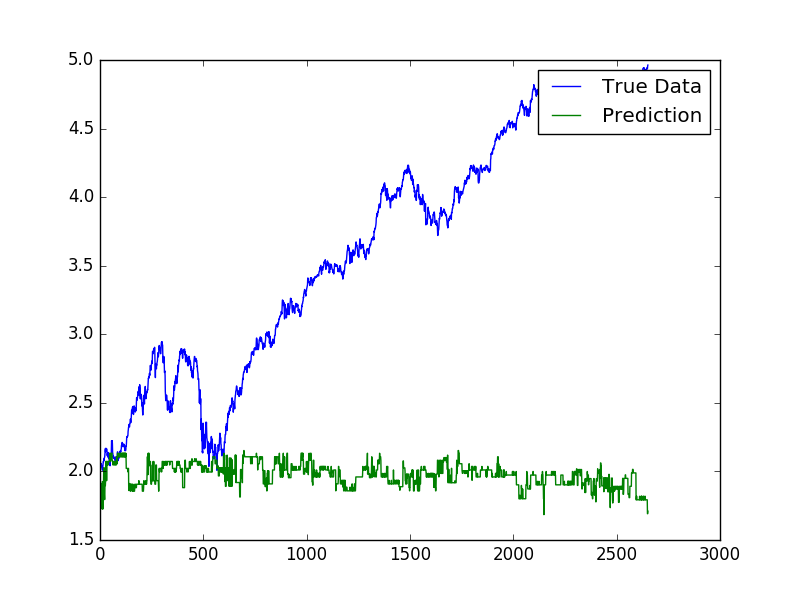

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(gbt_predictions.select('label').rdd.map(lambda row : row[0]).collect(), label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(gbt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
plt.legend()
display(fig)

In [53]:
dt = DecisionTreeRegressor()

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(dt.maxBins, [32, 16, 64]) \
    .addGrid(dt.maxDepth, [5, 10])\
    .build()

tvs = TrainValidationSplit(estimator=dt,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)


In [54]:
train_df_daily = train_df.withColumnRenamed("pred_daily", "label").select("features", "label")
test_df_daily = test_df.withColumnRenamed("pred_daily", "label").select("features", "label")
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_df_daily)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
dt_predictions = model.transform(test_df_daily)

dt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % dt_evaluator.evaluate(dt_predictions))

RMSE on test data = 1.88197

In [55]:
print(smape(np.array(dt_predictions.select('label').rdd.map(lambda row : row[0]).collect()), np.array(dt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect())))

57.2214612877

In [56]:
model.bestModel.featureImportances

Out[ 30 ]: SparseVector(41, {0: 0.995, 1: 0.0019, 2: 0.0002, 3: 0.0009, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0014, 38: 0.0001, 39: 0.0, 40: 0.0})

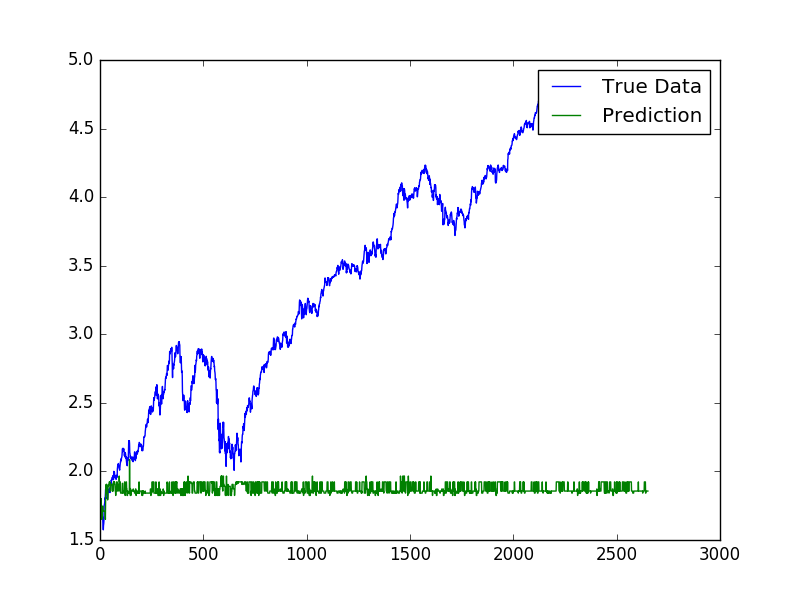

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dt_predictions.select('label').rdd.map(lambda row : row[0]).collect(), label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(dt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
plt.legend()
display(fig)

In [58]:
train_df_weekly = train_df.withColumnRenamed("pred_weekly", "label").select("features", "label")
test_df_weekly = test_df.withColumnRenamed("pred_weekly", "label").select("features", "label")
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_df_weekly)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
dt_predictions = model.transform(test_df_weekly)

dt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % dt_evaluator.evaluate(dt_predictions))

RMSE on test data = 2.08928

In [59]:
print(smape(np.array(dt_predictions.select('label').rdd.map(lambda row : row[0]).collect()), np.array(dt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect())))

66.9597550366

In [60]:
model.bestModel.featureImportances

Out[ 34 ]: SparseVector(41, {0: 0.9093, 1: 0.0, 2: 0.0771, 3: 0.0021, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0001, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0001, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0001, 25: 0.0003, 26: 0.0001, 27: 0.0001, 28: 0.0001, 29: 0.0001, 30: 0.0004, 31: 0.0001, 32: 0.0002, 33: 0.0001, 34: 0.0069, 35: 0.0002, 36: 0.0001, 37: 0.0015, 38: 0.0005, 39: 0.0002, 40: 0.0})

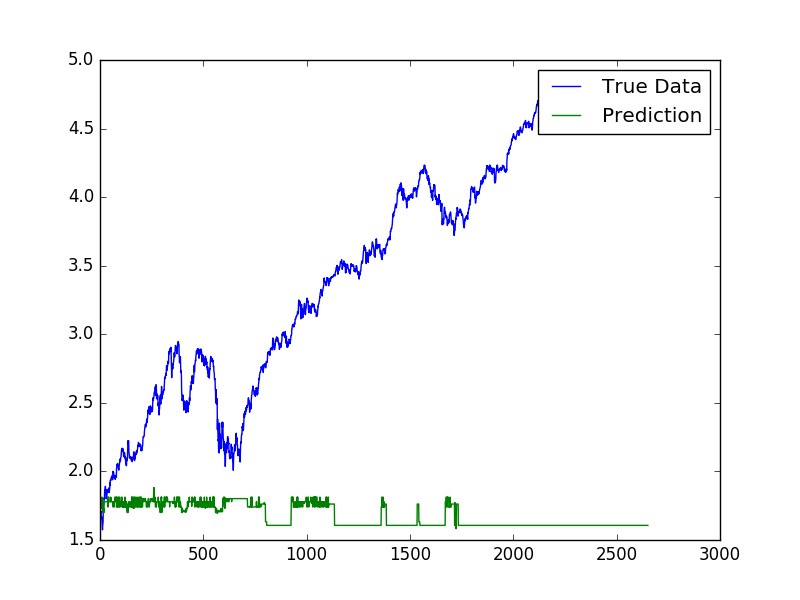

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dt_predictions.select('label').rdd.map(lambda row : row[0]).collect(), label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(dt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
plt.legend()
display(fig)

In [62]:
train_df_biweekly = train_df.withColumnRenamed("pred_biweekly", "label").select("features", "label")
test_df_biweekly = test_df.withColumnRenamed("pred_biweekly", "label").select("features", "label")
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_df_biweekly)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
dt_predictions = model.transform(test_df_biweekly)

dt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % dt_evaluator.evaluate(dt_predictions))

RMSE on test data = 1.98065

In [63]:
print(smape(np.array(dt_predictions.select('label').rdd.map(lambda row : row[0]).collect()), np.array(dt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect())))

62.9718496181

In [64]:
model.bestModel.featureImportances

Out[ 38 ]: SparseVector(41, {0: 0.916, 1: 0.0, 2: 0.061, 3: 0.0006, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0001, 8: 0.0001, 9: 0.0031, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0001, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0002, 19: 0.0, 20: 0.0, 21: 0.0001, 22: 0.0002, 23: 0.0001, 24: 0.0001, 25: 0.0005, 26: 0.0001, 27: 0.0004, 28: 0.0002, 29: 0.0087, 30: 0.001, 31: 0.0002, 32: 0.0003, 33: 0.0002, 34: 0.0002, 35: 0.0005, 36: 0.0036, 37: 0.0003, 38: 0.0017, 39: 0.0003, 40: 0.0})

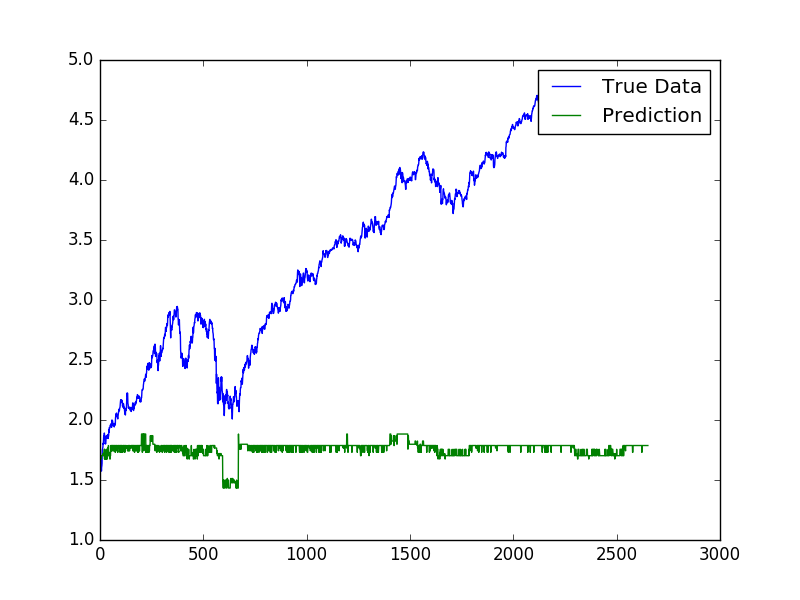

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dt_predictions.select('label').rdd.map(lambda row : row[0]).collect(), label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(dt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
plt.legend()
display(fig)

In [66]:
train_df_monthly = train_df.withColumnRenamed("pred_monthly", "label").select("features", "label")
test_df_monthly = test_df.withColumnRenamed("pred_monthly", "label").select("features", "label")
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_df_monthly)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
dt_predictions = model.transform(test_df_monthly)

dt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % dt_evaluator.evaluate(dt_predictions))

RMSE on test data = 2.04229

In [67]:
print(smape(np.array(dt_predictions.select('label').rdd.map(lambda row : row[0]).collect()), np.array(dt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect())))

66.4408969607

In [68]:
model.bestModel.featureImportances

Out[ 42 ]: SparseVector(41, {0: 0.8917, 1: 0.0, 2: 0.0805, 3: 0.0005, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0001, 8: 0.0005, 9: 0.0037, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0001, 21: 0.0002, 22: 0.0, 23: 0.0, 24: 0.0003, 25: 0.0001, 26: 0.0004, 27: 0.0003, 28: 0.0001, 29: 0.0154, 30: 0.0018, 31: 0.0002, 32: 0.0005, 33: 0.0002, 34: 0.0004, 35: 0.0003, 36: 0.0002, 37: 0.0004, 38: 0.0011, 39: 0.0006, 40: 0.0})

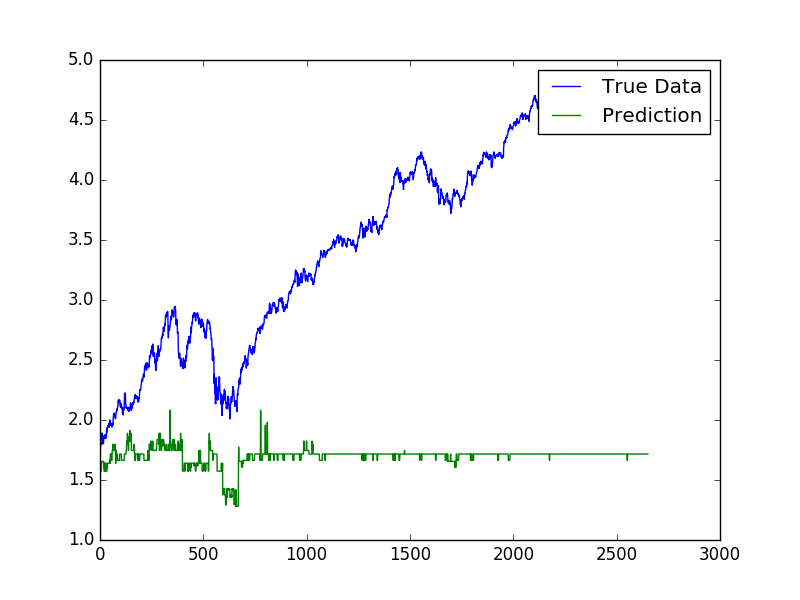

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dt_predictions.select('label').rdd.map(lambda row : row[0]).collect(), label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(dt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
plt.legend()
display(fig)

In [70]:
train_df_quarterly = train_df.withColumnRenamed("pred_quarterly", "label").select("features", "label")
test_df_quarterly = test_df.withColumnRenamed("pred_quarterly", "label").select("features", "label")
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train_df_quarterly)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
dt_predictions = model.transform(test_df_quarterly)

dt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % dt_evaluator.evaluate(dt_predictions))

RMSE on test data = 2.13426

In [71]:
print(smape(np.array(dt_predictions.select('label').rdd.map(lambda row : row[0]).collect()), np.array(dt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect())))

69.9256275154

In [72]:
model.bestModel.featureImportances

Out[ 46 ]: SparseVector(41, {0: 0.9457, 1: 0.0001, 2: 0.0007, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0001, 8: 0.0003, 9: 0.0025, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0001, 17: 0.0, 18: 0.0001, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0002, 23: 0.0, 24: 0.0001, 25: 0.0002, 26: 0.0003, 27: 0.0001, 28: 0.0001, 29: 0.0117, 30: 0.0013, 31: 0.0005, 32: 0.0036, 33: 0.0065, 34: 0.0009, 35: 0.0006, 36: 0.0016, 37: 0.0082, 38: 0.0137, 39: 0.0008, 40: 0.0})

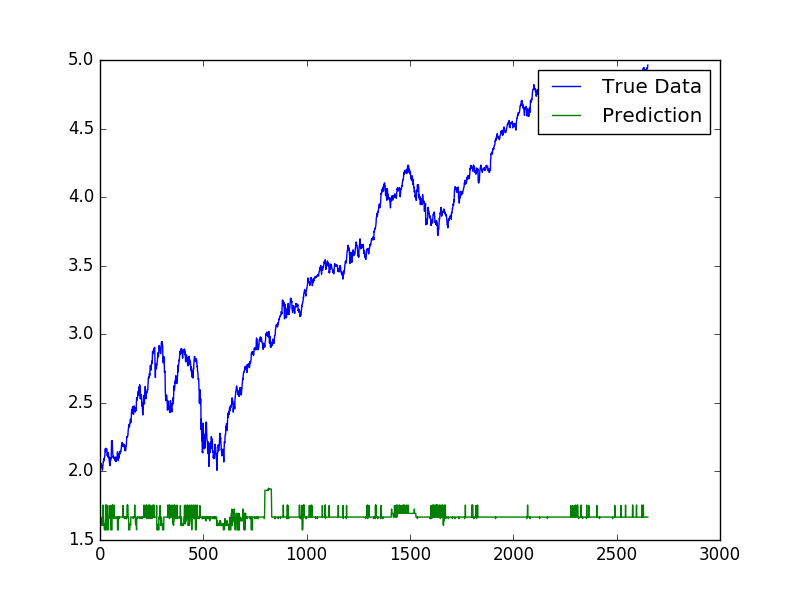

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dt_predictions.select('label').rdd.map(lambda row : row[0]).collect(), label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(dt_predictions.select('prediction').rdd.map(lambda row : row[0]).collect(), label='Prediction')
plt.legend()
display(fig)

LSTM Model

In [7]:
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import time

In [4]:
# Step 1 Load Data
df = pd.read_csv('AAPL.csv')
df = df.drop(['Date','Unnamed: 0'],axis=1)
df['log_returns'] = np.log(df['Adj_close'])- np.log(df['Adj_close'].shift(1))
df.head()
df.to_csv('AAPL.csv')

In [5]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
temp = min_max_scaler.fit_transform(df)
my_array = np.array(temp)



X = my_array[:, :-1]
Y = my_array[:, -1]
x_train, x_test = X[1:math.floor(len(X)*0.8)], X[math.ceil(len(X)*0.8):-1]
y_train, y_test = Y[1:math.floor(len(X)*0.8)], Y[math.ceil(len(X)*0.8):-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 

C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [8]:
# Step 2 Build Model
model1 = Sequential()

model1.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model1.add(Dropout(0.4))

model1.add(LSTM(
    100,
    return_sequences=False))
model1.add(Dropout(0.4))

model1.add(Dense(
    output_dim=1))
model1.add(Activation('linear'))

start = time.time()
model1.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  import sys


compilation time :  0.029743432998657227


C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


In [9]:
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(len(data) // prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [10]:
model1.fit(
    x_train,
    y_train,
    batch_size=7271,
    nb_epoch=10,
    validation_split=0.05)

C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 6907 samples, validate on 364 samples
Epoch 1/10
6907/6907 [==============================] - 22s 3ms/step - loss: 0.5228 - val_loss: 0.4343
Epoch 2/10
6907/6907 [==============================] - 15s 2ms/step - loss: 0.4351 - val_loss: 0.3198
Epoch 3/10
6907/6907 [==============================] - 15s 2ms/step - loss: 0.3221 - val_loss: 0.1026
Epoch 4/10
6907/6907 [==============================] - 15s 2ms/step - loss: 0.1064 - val_loss: 6.8352
Epoch 5/10
6907/6907 [==============================] - 14s 2ms/step - loss: 6.9494 - val_loss: 0.1559
Epoch 6/10
6907/6907 [==============================] - 14s 2ms/step - loss: 0.1592 - val_loss: 0.1390
Epoch 7/10
6907/6907 [==============================] - 16s 2ms/step - loss: 0.1424 - val_loss: 0.1222
Epoch 8/10
6907/6907 [==============================] - 15s 2ms/step - loss: 0.1266 - val_loss: 0.1056
Epoch 9/10
6907/6907 [==============================] - 16s 2ms/step - loss: 0.1102 - val_loss: 0.0894
Epoch 10/10
6907/6907 [===

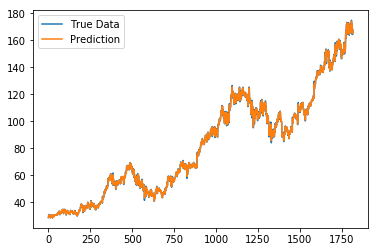

In [11]:

# Step 4 - Plot the predictions!
predictions_returns_day = np.array(predict_sequences_multiple(model1, x_test, 50, 1)).flatten()

# Convert everything back into prices
r0 = np.array(df['log_return'])[-len(predictions_returns_day):]
p0 = np.array(df['Adj_close'])[-len(predictions_returns_day):]
actual_prices = p0 * (np.exp((r0*y_test )))
predictions_day = p0 * (np.exp(r0*predictions_returns_day))

# Step 4 - Plot the predictions!
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(actual_prices, label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(predictions_day, label='Prediction')
plt.legend()
plt.show()

Week Model

In [12]:
# Step 1 Load Data
df = pd.read_csv('AAPL.csv')
df = df.drop(['Date','Unnamed: 0'],axis=1)
df['log_returns'] = np.log(df['Adj_close'])- np.log(df['Adj_close'].shift(5))
df.head(10)

,Open,High,Low,Close,Volume,log_return,weekly_mean,biweekly_mean,monthly_mean,bimonthly_mean,...,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Adj_close,log_returns
0,0.328125,0.328125,0.323661,0.323661,6311200,-0.033959,-0.010751,-0.002727,-0.003484,0.000000,...,0,0,0,0,0,0,0,1,0.014504,NaN
1,0.332589,0.334821,0.332589,0.332589,7828800,0.027272,-0.001337,0.000000,0.001299,0.000160,...,0,0,0,0,0,0,0,1,0.014905,NaN
2,0.348214,0.350446,0.348214,0.348214,16363200,0.045895,0.006513,0.003921,0.004145,0.001578,...,0,0,0,0,0,0,0,1,0.015605,NaN
3,0.377232,0.379464,0.377232,0.377232,12863200,0.080018,0.022517,0.013264,0.006967,0.002998,...,0,0,0,0,0,0,0,1,0.016905,NaN
4,0.408482,0.410714,0.408482,0.408482,17931200,0.079619,0.039769,0.018560,0.009153,0.003649,...,0,0,0,0,0,0,0,1,0.018306,NaN
5,0.392857,0.392857,0.390625,0.390625,14100800,-0.044742,0.037612,0.013431,0.007022,0.002584,...,0,0,0,0,0,0,0,1,0.017505,0.188062
6,0.397321,0.399554,0.397321,0.397321,13456800,0.016993,0.035557,0.017110,0.007517,0.003140,...,0,0,0,0,0,0,0,1,0.017805,0.177783
7,0.390625,0.390625,0.388393,0.388393,7224000,-0.022722,0.021833,0.014173,0.008683,0.003217,...,0,0,0,0,0,0,0,1,0.017405,0.109166
8,0.390625,0.392857,0.390625,0.390625,7229600,0.005729,0.006975,0.014746,0.009285,0.003354,...,0,0,0,0,0,0,0,1,0.017505,0.034877
9,0.377232,0.377232,0.372768,0.372768,9144800,-0.046778,-0.018304,0.010732,0.006072,0.001775,...,0,0,0,0,0,0,0,1,0.016705,-0.091521


In [22]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
temp = min_max_scaler.fit_transform(df)
my_array = np.array(temp)



X = my_array[:, :-1]
Y = my_array[:, -1]
x_train, x_test = X[5:math.floor(len(X)*0.8)], X[math.ceil(len(X)*0.8):-1]
y_train, y_test = Y[5:math.floor(len(X)*0.8)], Y[math.ceil(len(X)*0.8):-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [23]:
# Step 2 Build Model
model2 = Sequential()

model2.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model2.add(Dropout(0.4))

model2.add(LSTM(
    100,
    return_sequences=False))
model2.add(Dropout(0.4))

model2.add(Dense(
    output_dim=1))
model2.add(Activation('linear'))

start = time.time()
model2.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  import sys


compilation time :  0.02989792823791504


C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


In [18]:
model2.fit(
    x_train,
    y_train,
    batch_size=7271,
    nb_epoch=10,
    validation_split=0.05)

C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 6903 samples, validate on 364 samples
Epoch 1/10
6903/6903 [==============================] - 17s 3ms/step - loss: 0.4077 - val_loss: 0.3282
Epoch 2/10
6903/6903 [==============================] - 16s 2ms/step - loss: 0.3268 - val_loss: 0.2147
Epoch 3/10
6903/6903 [==============================] - 15s 2ms/step - loss: 0.2155 - val_loss: 0.0200
Epoch 4/10
6903/6903 [==============================] - 15s 2ms/step - loss: 0.0256 - val_loss: 7.2639
Epoch 5/10
6903/6903 [==============================] - 14s 2ms/step - loss: 7.3691 - val_loss: 0.0945
Epoch 6/10
6903/6903 [==============================] - 15s 2ms/step - loss: 0.0972 - val_loss: 0.0833
Epoch 7/10
6903/6903 [==============================] - 14s 2ms/step - loss: 0.0865 - val_loss: 0.0724
Epoch 8/10
6903/6903 [==============================] - 14s 2ms/step - loss: 0.0754 - val_loss: 0.0620
Epoch 9/10
6903/6903 [==============================] - 14s 2ms/step - loss: 0.0655 - val_loss: 0.0521
Epoch 10/10
6903/6903 [===

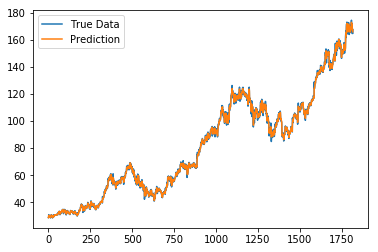

In [24]:
predictions_returns_week = np.array(predict_sequences_multiple(model2, x_test, 50, 1)).flatten()
# Convert everything back into prices
r0 = np.array(df['log_return'])[-len(predictions_returns_week):]
p0 = np.array(df['Adj_close'])[-len(predictions_returns_week):]
actual_prices = p0 * (np.exp((r0*y_test )))
predictions_week = p0 * (np.exp(r0*predictions_returns_week))

# Step 4 - Plot the predictions!
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(actual_prices, label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(predictions_week, label='Prediction')
plt.legend()
plt.show()

2 weeks

In [43]:
# Step 1 Load Data
df = pd.read_csv('AAPL.csv')
df = df.drop(['Date','Unnamed: 0'],axis=1)
df['log_returns'] = np.log(df['Adj_close'])- np.log(df['Adj_close'].shift(10))
df.head(15)

,Open,High,Low,Close,Volume,log_return,weekly_mean,biweekly_mean,monthly_mean,bimonthly_mean,...,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Adj_close,log_returns
0,0.328125,0.328125,0.323661,0.323661,6311200,-0.033959,-0.010751,-0.002727,-0.003484,0.000000,...,0,0,0,0,0,0,0,1,0.014504,NaN
1,0.332589,0.334821,0.332589,0.332589,7828800,0.027272,-0.001337,0.000000,0.001299,0.000160,...,0,0,0,0,0,0,0,1,0.014905,NaN
2,0.348214,0.350446,0.348214,0.348214,16363200,0.045895,0.006513,0.003921,0.004145,0.001578,...,0,0,0,0,0,0,0,1,0.015605,NaN
3,0.377232,0.379464,0.377232,0.377232,12863200,0.080018,0.022517,0.013264,0.006967,0.002998,...,0,0,0,0,0,0,0,1,0.016905,NaN
4,0.408482,0.410714,0.408482,0.408482,17931200,0.079619,0.039769,0.018560,0.009153,0.003649,...,0,0,0,0,0,0,0,1,0.018306,NaN
5,0.392857,0.392857,0.390625,0.390625,14100800,-0.044742,0.037612,0.013431,0.007022,0.002584,...,0,0,0,0,0,0,0,1,0.017505,NaN
6,0.397321,0.399554,0.397321,0.397321,13456800,0.016993,0.035557,0.017110,0.007517,0.003140,...,0,0,0,0,0,0,0,1,0.017805,NaN
7,0.390625,0.390625,0.388393,0.388393,7224000,-0.022722,0.021833,0.014173,0.008683,0.003217,...,0,0,0,0,0,0,0,1,0.017405,NaN
8,0.390625,0.392857,0.390625,0.390625,7229600,0.005729,0.006975,0.014746,0.009285,0.003354,...,0,0,0,0,0,0,0,1,0.017505,NaN
9,0.377232,0.377232,0.372768,0.372768,9144800,-0.046778,-0.018304,0.010732,0.006072,0.001775,...,0,0,0,0,0,0,0,1,0.016705,NaN


In [44]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
temp = min_max_scaler.fit_transform(df)
my_array = np.array(temp)



X = my_array[:, :-1]
Y = my_array[:, -1]
x_train, x_test = X[10:math.floor(len(X)*0.8)], X[math.ceil(len(X)*0.8):-1]
y_train, y_test = Y[10:math.floor(len(X)*0.8)], Y[math.ceil(len(X)*0.8):-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [45]:
# Step 2 Build Model
model3 = Sequential()

model3.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model3.add(Dropout(0.4))

model3.add(LSTM(
    100,
    return_sequences=False))
model3.add(Dropout(0.4))

model3.add(Dense(
    output_dim=1))
model3.add(Activation('linear'))

start = time.time()
model3.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  import sys


compilation time :  0.03956007957458496


C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


In [47]:
model3.fit(
    x_train,
    y_train,
    batch_size=7271,
    nb_epoch=10,
    validation_split=0.05)

C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 6898 samples, validate on 364 samples
Epoch 1/10
6898/6898 [==============================] - 16s 2ms/step - loss: 0.3977 - val_loss: 0.3277
Epoch 2/10
6898/6898 [==============================] - 16s 2ms/step - loss: 0.3230 - val_loss: 0.2366
Epoch 3/10
6898/6898 [==============================] - 16s 2ms/step - loss: 0.2344 - val_loss: 0.0782
Epoch 4/10
6898/6898 [==============================] - 14s 2ms/step - loss: 0.0805 - val_loss: 1.9355
Epoch 5/10
6898/6898 [==============================] - 15s 2ms/step - loss: 1.9760 - val_loss: 0.1247
Epoch 6/10
6898/6898 [==============================] - 15s 2ms/step - loss: 0.1258 - val_loss: 0.1148
Epoch 7/10
6898/6898 [==============================] - 14s 2ms/step - loss: 0.1164 - val_loss: 0.1050
Epoch 8/10
6898/6898 [==============================] - 14s 2ms/step - loss: 0.1065 - val_loss: 0.0951
Epoch 9/10
6898/6898 [==============================] - 14s 2ms/step - loss: 0.0968 - val_loss: 0.0850
Epoch 10/10
6898/6898 [===

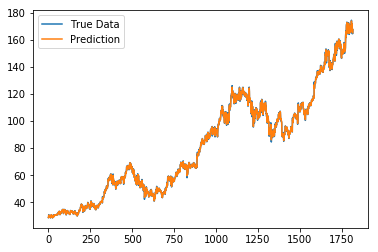

In [48]:
predictions_returns_2week = np.array(predict_sequences_multiple(model3, x_test, 50, 1)).flatten()

# Convert everything back into prices
r0 = np.array(df['log_return'])[-len(predictions_returns_2week):]
p0 = np.array(df['Adj_close'])[-len(predictions_returns_2week):]
actual_prices = p0 * (np.exp((r0*y_test )))
predictions_2week = p0 * (np.exp(r0*predictions_returns_2week))

# Step 4 - Plot the predictions!
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(actual_prices, label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(predictions_2week, label='Prediction')
plt.legend()
plt.show()

Month

In [49]:
# Step 1 Load Data
df = pd.read_csv('AAPL.csv')
df = df.drop(['Date','Unnamed: 0'],axis=1)
df['log_returns'] = np.log(df['Adj_close'])- np.log(df['Adj_close'].shift(21))
df.head(15)

,Open,High,Low,Close,Volume,log_return,weekly_mean,biweekly_mean,monthly_mean,bimonthly_mean,...,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Adj_close,log_returns
0,0.328125,0.328125,0.323661,0.323661,6311200,-0.033959,-0.010751,-0.002727,-0.003484,0.000000,...,0,0,0,0,0,0,0,1,0.014504,NaN
1,0.332589,0.334821,0.332589,0.332589,7828800,0.027272,-0.001337,0.000000,0.001299,0.000160,...,0,0,0,0,0,0,0,1,0.014905,NaN
2,0.348214,0.350446,0.348214,0.348214,16363200,0.045895,0.006513,0.003921,0.004145,0.001578,...,0,0,0,0,0,0,0,1,0.015605,NaN
3,0.377232,0.379464,0.377232,0.377232,12863200,0.080018,0.022517,0.013264,0.006967,0.002998,...,0,0,0,0,0,0,0,1,0.016905,NaN
4,0.408482,0.410714,0.408482,0.408482,17931200,0.079619,0.039769,0.018560,0.009153,0.003649,...,0,0,0,0,0,0,0,1,0.018306,NaN
5,0.392857,0.392857,0.390625,0.390625,14100800,-0.044742,0.037612,0.013431,0.007022,0.002584,...,0,0,0,0,0,0,0,1,0.017505,NaN
6,0.397321,0.399554,0.397321,0.397321,13456800,0.016993,0.035557,0.017110,0.007517,0.003140,...,0,0,0,0,0,0,0,1,0.017805,NaN
7,0.390625,0.390625,0.388393,0.388393,7224000,-0.022722,0.021833,0.014173,0.008683,0.003217,...,0,0,0,0,0,0,0,1,0.017405,NaN
8,0.390625,0.392857,0.390625,0.390625,7229600,0.005729,0.006975,0.014746,0.009285,0.003354,...,0,0,0,0,0,0,0,1,0.017505,NaN
9,0.377232,0.377232,0.372768,0.372768,9144800,-0.046778,-0.018304,0.010732,0.006072,0.001775,...,0,0,0,0,0,0,0,1,0.016705,NaN


In [50]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
temp = min_max_scaler.fit_transform(df)
my_array = np.array(temp)



X = my_array[:, :-1]
Y = my_array[:, -1]
x_train, x_test = X[21:math.floor(len(X)*0.8)], X[math.ceil(len(X)*0.8):-1]
y_train, y_test = Y[21:math.floor(len(X)*0.8)], Y[math.ceil(len(X)*0.8):-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [51]:
# Step 2 Build Model
model4 = Sequential()

model4.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model4.add(Dropout(0.4))

model4.add(LSTM(
    100,
    return_sequences=False))
model4.add(Dropout(0.4))

model4.add(Dense(
    output_dim=1))
model4.add(Activation('linear'))

start = time.time()
model4.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  import sys


compilation time :  0.037628173828125


C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


In [52]:
model4.fit(
    x_train,
    y_train,
    batch_size=7271,
    nb_epoch=10,
    validation_split=0.05)

C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 6888 samples, validate on 363 samples
Epoch 1/10
6888/6888 [==============================] - 16s 2ms/step - loss: 0.3870 - val_loss: 0.3099
Epoch 2/10
6888/6888 [==============================] - 14s 2ms/step - loss: 0.3011 - val_loss: 0.1849
Epoch 3/10
6888/6888 [==============================] - 15s 2ms/step - loss: 0.1804 - val_loss: 0.0129
Epoch 4/10
6888/6888 [==============================] - 15s 2ms/step - loss: 0.0271 - val_loss: 0.1683
Epoch 5/10
6888/6888 [==============================] - 15s 2ms/step - loss: 0.1653 - val_loss: 0.0777
Epoch 6/10
6888/6888 [==============================] - 15s 2ms/step - loss: 0.0788 - val_loss: 0.0035
Epoch 7/10
6888/6888 [==============================] - 14s 2ms/step - loss: 0.0123 - val_loss: 0.0029
Epoch 8/10
6888/6888 [==============================] - 15s 2ms/step - loss: 0.0143 - val_loss: 0.0215
Epoch 9/10
6888/6888 [==============================] - 14s 2ms/step - loss: 0.0271 - val_loss: 0.0137
Epoch 10/10
6888/6888 [===

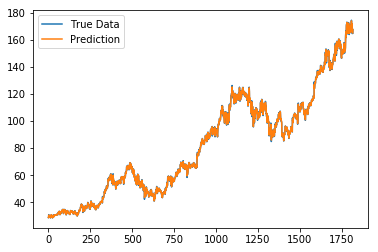

In [53]:
predictions_returns_month = np.array(predict_sequences_multiple(model4, x_test, 50, 1)).flatten()
# Convert everything back into prices
r0 = np.array(df['log_return'])[-len(predictions_returns_month):]
p0 = np.array(df['Adj_close'])[-len(predictions_returns_month):]
actual_prices = p0 * (np.exp((r0*y_test )))
predictions_month = p0 * (np.exp(r0*predictions_returns_month))

# Step 4 - Plot the predictions!
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(actual_prices, label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(predictions_month, label='Prediction')
plt.legend()
plt.show()

Quarter

In [32]:
# Step 1 Load Data
df = pd.read_csv('AAPL.csv')
df = df.drop(['Date','Unnamed: 0'],axis=1)
df['log_returns'] = np.log(df['Adj_close'])- np.log(df['Adj_close'].shift(63))

In [33]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
temp = min_max_scaler.fit_transform(df)
my_array = np.array(temp)

X = my_array[:, :-1]
Y = my_array[:, -1]
x_train, x_test = X[63:math.floor(len(X)*0.8)], X[math.ceil(len(X)*0.8):-1]
y_train, y_test = Y[63:math.floor(len(X)*0.8)], Y[math.ceil(len(X)*0.8):-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [34]:
# Step 2 Build Model
model5 = Sequential()

model5.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model5.add(Dropout(0.4))

model5.add(LSTM(
    100,
    return_sequences=False))
model5.add(Dropout(0.4))

model5.add(Dense(
    output_dim=1))
model5.add(Activation('linear'))

start = time.time()
model5.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  import sys


compilation time :  0.04089188575744629


C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


In [35]:
model5.fit(
    x_train,
    y_train,
    batch_size=7271,
    nb_epoch=10,
    validation_split=0.05)

C:\Users\Aron\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 6848 samples, validate on 361 samples
Epoch 1/10
6848/6848 [==============================] - 20s 3ms/step - loss: 0.4288 - val_loss: 0.3858
Epoch 2/10
6848/6848 [==============================] - 16s 2ms/step - loss: 0.3485 - val_loss: 0.2782
Epoch 3/10
6848/6848 [==============================] - 15s 2ms/step - loss: 0.2497 - val_loss: 0.0812
Epoch 4/10
6848/6848 [==============================] - 14s 2ms/step - loss: 0.0744 - val_loss: 4.9120
Epoch 5/10
6848/6848 [==============================] - 14s 2ms/step - loss: 5.1487 - val_loss: 0.1408
Epoch 6/10
6848/6848 [==============================] - 13s 2ms/step - loss: 0.1258 - val_loss: 0.1318
Epoch 7/10
6848/6848 [==============================] - 13s 2ms/step - loss: 0.1180 - val_loss: 0.1227
Epoch 8/10
6848/6848 [==============================] - 15s 2ms/step - loss: 0.1098 - val_loss: 0.1136
Epoch 9/10
6848/6848 [==============================] - 14s 2ms/step - loss: 0.1019 - val_loss: 0.1045
Epoch 10/10
6848/6848 [===

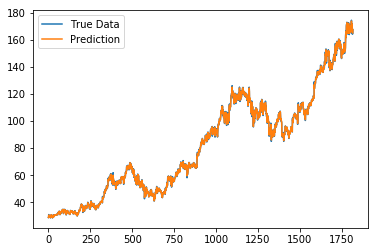

In [38]:
predictions_returns_4month = np.array(predict_sequences_multiple(model5, x_test, 50, 1)).flatten()
# Convert everything back into prices
r0 = np.array(df['log_return'])[-len(predictions_returns_4month):]
p0 = np.array(df['Adj_close'])[-len(predictions_returns_4month):]
actual_prices = p0 * (np.exp((r0*y_test )))
predictions_4month = p0 * (np.exp(r0*predictions_returns_4month))

# Step 4 - Plot the predictions!
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(actual_prices, label='True Data')
#Pad the list of predictions to shift it in the graph to it's correct start
ax.plot(predictions_4month, label='Prediction')
plt.legend()
plt.show()

In [54]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms_day = sqrt(mean_squared_error(actual_prices, predictions_day))
rms_week = sqrt(mean_squared_error(actual_prices, predictions_week))
rms_2week = sqrt(mean_squared_error(actual_prices, predictions_2week))
rms_month = sqrt(mean_squared_error(actual_prices, predictions_month))
rms_quarter = sqrt(mean_squared_error(actual_prices, predictions_4month))

In [55]:
print(rms_day)
print(rms_week)
print(rms_2week)
print(rms_month)
print(rms_quarter)

0.198003045904195
0.7782777575577259
0.310520235159872
0.2708482848362032
0.29288112422562845


In [56]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [57]:
smape_day = smape(actual_prices, predictions_day)
smape_week = smape(actual_prices, predictions_week)
smape_2week = smape(actual_prices, predictions_2week)
smape_month = smape(actual_prices, predictions_month)
smape_quarter = smape(actual_prices, predictions_4month)

In [58]:
print(smape_day)
print(smape_week)
print(smape_2week)
print(smape_month)
print(smape_quarter)

0.1777036326147246
0.689794282019644
0.27907948989494724
0.24426364319872915
0.26270481388102074
